
## Dataset
https://github.com/fouadtrad/Detecting-Quishing-Attacks-with-Machine-Learning-Techniques-Through-QR-Code-Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy pandas matplotlib scikit-learn opencv-python pyzbar

In [ ]:
import os
import re
import cv2
import csv
import joblib
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier


### Filter the dataset to include only QR codes that can be successfully decoded into a URL, and save those results to Google Drive.



In [ ]:
drive_dir = '/content/drive/MyDrive/ScanQR'
pickle_x = f'{drive_dir}/qr_codes_29.pickle'
pickle_y = f'{drive_dir}/qr_codes_29_labels.pickle'
save_dir = f'{drive_dir}/decoded_images'
csv_path = f'{drive_dir}/decoded_qr_links.csv'

os.makedirs(save_dir, exist_ok=True)

with open(pickle_x, 'rb') as f:
    X = pickle.load(f)

with open(pickle_y, 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} images, {len(y)} labels")

def enhance_and_decode(img):
    img = (img * 255).astype('uint8') if img.max() <= 1.0 else img
    if img.ndim == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    big = cv2.resize(gray, (600, 600), interpolation=cv2.INTER_NEAREST)

    bordered = cv2.copyMakeBorder(big, 80, 80, 80, 80, cv2.BORDER_CONSTANT, value=255)

    blur = cv2.GaussianBlur(bordered, (3, 3), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    det = cv2.QRCodeDetector()
    data, _, _ = det.detectAndDecode(th)
    return data

decoded_results = []
decoded_count = 0

for i in range(len(X)):
    label = int(y[i])
    decoded = enhance_and_decode(X[i])

    if decoded:
        decoded_count += 1
        decoded_results.append((i, label, decoded))

        img = (X[i] * 255).astype('uint8') if X[i].max() <= 1.0 else X[i]
        filename = f"{'benign' if label == 0 else 'phishing'}_{i}.png"
        cv2.imwrite(os.path.join(save_dir, filename), img)

with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'label', 'decoded_text'])
    writer.writerows(decoded_results)

print(f"\n Decoded {decoded_count} out of {len(X)} images")
print(f"Images saved to: {save_dir}")
print(f"CSV saved to: {csv_path}")


Loaded 9987 images, 9987 labels

 Decoded 8594 out of 9987 images
Images saved to: /content/drive/MyDrive/ScanQR/decoded_images
CSV saved to: /content/drive/MyDrive/ScanQR/decoded_qr_links.csv


### Display example QR codes: one phishing and one benign

Found 8594 decoded images


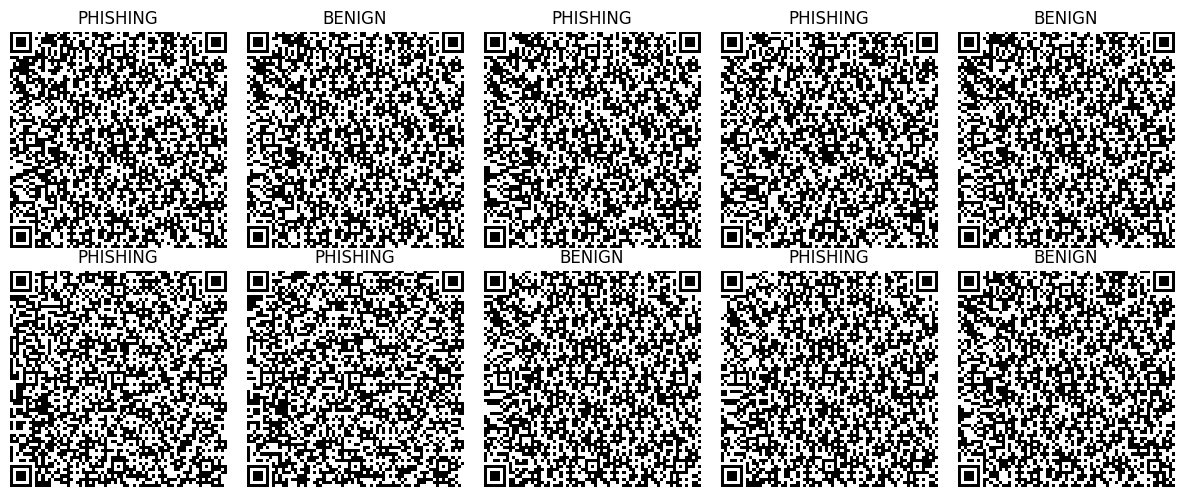

In [ ]:
base_dir = '/content/drive/MyDrive/ScanQR'
save_dir = f'{base_dir}/decoded_images'

image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]
print(f"Found {len(image_files)} decoded images")

sample_files = random.sample(image_files, min(10, len(image_files)))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, filename in zip(axes.flat, sample_files):
    path = os.path.join(save_dir, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = "BENIGN" if "benign" in filename else "PHISHING"
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Example of ML model


This model learns from two types of features: visual patterns from the QR images and textual characteristics from the decoded URLs. The image features come from pixel intensity values that capture QR structure, contrast, and noise patterns that may differ between legitimate and phishing codes. The URL features include aspects like length, number of digits, presence of HTTPS or IP addresses, special characters, and subdomains.

In [ ]:
base_dir = '/content/drive/MyDrive/ScanQR'
decoded_dir = f'{base_dir}/decoded_images'
csv_path = f'{base_dir}/decoded_qr_links.csv'

# -------------------------
# 1. Load decoded QR images
# -------------------------
X = []
y = []

for filename in os.listdir(decoded_dir):
    if filename.endswith('.png'):
        path = os.path.join(decoded_dir, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            X.append(img)
            label = 0 if 'benign' in filename.lower() else 1
            y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} decoded images from: {decoded_dir}")
print("Label distribution:", Counter(y))

# -------------------------
# 2. Load decoded QR links (textual data)
# -------------------------
if os.path.exists(csv_path):
    decoded_df = pd.read_csv(csv_path)
    print(f"Loaded {len(decoded_df)} decoded links from CSV.")
else:
    decoded_df = None
    print("⚠️ CSV file not found, continuing with image-only features.")

# -------------------------
# 3. Preprocess images
# -------------------------
Xf = X.reshape((X.shape[0], -1)).astype('float32') / 255.0
print(f"Image feature matrix shape: {Xf.shape}")

# -------------------------
# 4. Extract URL-based features
# -------------------------
if decoded_df is not None and 'decoded_text' in decoded_df.columns:
    print("\nExtracting text-based URL features...")

    decoded_df['decoded_text'] = decoded_df['decoded_text'].fillna('')
    decoded_df['url_length'] = decoded_df['decoded_text'].apply(len)
    decoded_df['num_digits'] = decoded_df['decoded_text'].apply(lambda x: sum(c.isdigit() for c in x))
    decoded_df['has_https'] = decoded_df['decoded_text'].apply(lambda x: int('https' in x))
    decoded_df['has_ip'] = decoded_df['decoded_text'].apply(
        lambda x: int(bool(re.search(r'\b\d{1,3}(\.\d{1,3}){3}\b', x)))
    )
    decoded_df['num_special_chars'] = decoded_df['decoded_text'].apply(
        lambda x: sum(not c.isalnum() for c in x)
    )
    decoded_df['num_subdomains'] = decoded_df['decoded_text'].apply(lambda x: x.count('.'))

    url_features = decoded_df[['url_length', 'num_digits', 'has_https', 'has_ip',
                               'num_special_chars', 'num_subdomains']].values

    scaler = StandardScaler()
    url_features_scaled = scaler.fit_transform(url_features)

    n = min(len(Xf), len(url_features_scaled))
    combined_features = np.hstack((Xf[:n], url_features_scaled[:n]))
    y = y[:n]

else:
    combined_features = Xf

# -------------------------
# 5. Split train/test
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

# -------------------------
# 6. Train XGBoost
# -------------------------
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6
)
model.fit(X_train, y_train)

# -------------------------
# 7. Predict & Evaluate
# -------------------------
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

auc_score = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Evaluation on Test Set ===")
print(f"AUC:       {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["BENIGN", "PHISHING"]))

# -------------------------
# 8. Save Model
# -------------------------
model_path = os.path.join(base_dir, "quishing_xgb_decoded_combined.pkl")
joblib.dump(model, model_path)
print(f"\n Model saved to: {model_path}")


Loaded 8594 decoded images from: /content/drive/MyDrive/ScanQR/decoded_images
Label distribution: Counter({np.int64(1): 4316, np.int64(0): 4278})
Loaded 8594 decoded links from CSV.
Image feature matrix shape: (8594, 4761)

Extracting text-based URL features...

Training samples: 6875, Test samples: 1719
Train label distribution: Counter({np.int64(1): 3453, np.int64(0): 3422})
Test label distribution: Counter({np.int64(1): 863, np.int64(0): 856})


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:08:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation on Test Set ===
AUC:       0.9229
Precision: 0.8584
Recall:    0.8076
F1-score:  0.8322

Confusion Matrix:
 [[741 115]
 [166 697]]

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.82      0.87      0.84       856
    PHISHING       0.86      0.81      0.83       863

    accuracy                           0.84      1719
   macro avg       0.84      0.84      0.84      1719
weighted avg       0.84      0.84      0.84      1719


 Model saved to: /content/drive/MyDrive/ScanQR/quishing_xgb_decoded_combined.pkl
